In [1]:
# Loading in libraries necessary for CNN
import torch
import torch.nn as nn
import numpy as np
import os
import glob
from torch.utils.data import Dataset, DataLoader, TensorDataset
import pandas as pd
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from sklearn.model_selection import train_test_split
import math
import matplotlib.pyplot as plt
import time

# whether to run on GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")


Using cuda device


In [2]:
files = glob.glob('./Spectral_Data/spectral_data/1200MHz/*.csv')
print('Total number of files: ', len(files))

Total number of files:  10000


Establishing a Dataloader for 1200MHz dataset

In [3]:
class GHzData(Dataset):
    def __init__(self):
        # Data loading
        self.df = pd.concat(map(pd.read_csv, glob.glob(os.path.join('./Spectral_Data/spectral_data/1200MHz', 
                                                       'spectral_data_*.csv'))),ignore_index=True)
       
        self.df = self.df.drop(self.df.columns[0], axis=1).to_numpy()
        self.x = torch.from_numpy(self.df[:,:2]).float()
        self.y = torch.from_numpy(self.df[:,2:4]).float()
        self.num_samples = self.df.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.num_samples
    
  

In [4]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(2,5) # input layer to hidden
        self.relu = nn.ReLU() # activation function
        self.fc2 = nn.Linear(5,2) # input layer to output
            
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [5]:
model = NeuralNetwork()

In [6]:
# Establishing and loading data into notebook
dataset = GHzData()

#Splitting the data
train_X, test_X, train_y, test_y = train_test_split(dataset.x, dataset.y,
                                                    test_size=0.2)

# Creating datasets
train_dataset = TensorDataset(train_X, train_y)
test_dataset = TensorDataset(test_X, test_y)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [7]:
criterion = nn.MSELoss()

In [8]:
optimizer = SGD(model.parameters(), lr=0.001)

In [9]:
num_epochs = 3

In [10]:
# Training loop for model with epoch loss as output

x = time.time()

for e in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_dataloader.dataset)
    
    if(int(e) % 10) == 0:
        
        print(f'Epoch {e+1} loss: {epoch_loss:.4f}')

print(f'Time Elapsed: {round(time.time()-x, 5)} seconds')    

Epoch 1 loss: 0.0403
Time Elapsed: 1737.89351 seconds


In [11]:
# Evaluating Model Performance

model.eval() # Model to evaluation mode

total_loss = 0.0
total_correct = 0

# Loop for testing
for inputs, labels in test_dataloader:
    #Forward pass
    outputs = model(inputs)
    total_loss += loss.item() * inputs.size(0)
    
    _, labels = torch.max(labels,1)
    _, predicts = torch.max(outputs.data, 1)
    total_correct += (predicts == labels).sum().item()

mean_loss = total_loss / len(test_dataset)
accuracy = (total_correct / len(test_dataset))*100



In [12]:
print(f' Mean Loss of Function: {mean_loss}, Accuracy: {accuracy}')

 Mean Loss of Function: 0.006529996171593666, Accuracy: 99.9229090909091


In [13]:
model.eval()
with torch.no_grad():
    for inputs, _ in test_dataloader:
        predictions = model(inputs)

predictions_numpy = predictions.numpy()
pred = pd.DataFrame(predictions_numpy)
pred

,0,1
0,8.859688,0.027577
1,3.808775,0.032654
2,8.429623,0.028318
3,9.861869,0.026569
4,8.085548,0.028355
...,...,...
59,1.960441,0.034517
60,3.468713,0.032996
61,0.616198,0.035863
62,6.783312,0.029664


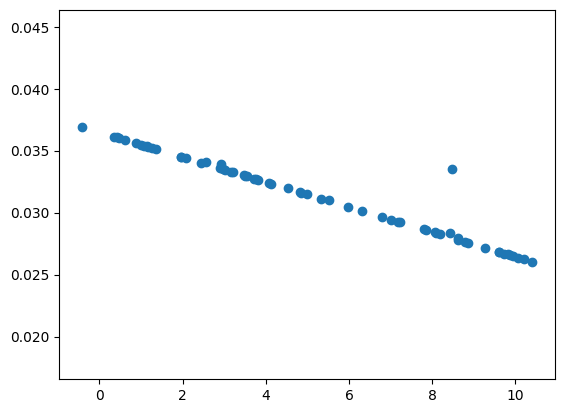

In [14]:
x = predictions_numpy[:, 0]
y = predictions_numpy[:, 1]

fig = plt.scatter(x,y)

In [15]:
# plotting the training and validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

NameError: name 'train_losses' is not defined